In [1]:
import numpy as np
from vowpalwabbit import pyvw
from newsenv import simple_news
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["tod"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [3]:
def train_offline(env,vw,input_df,actions):
    t_cost_sum = 0. #Training Algo
    t_ctr=[]        
    
    o_cost_sum=0.   #Optimal Algo
    o_ctr=[]
    
    off_cost_sum=0. #Offline collected data
    off_ctr=[]      
    for i in range(len(input_df)):
        action = input_df.loc[i, "action"]
        cost = input_df.loc[i, "cost"]
        prob = input_df.loc[i, "prob"]
        user = input_df.loc[i, "user"]
        tod = input_df.loc[i, "tod"]
        context={"user":user,"tod":tod}                    
        vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)            
        vw.learn(vw_format)
        
        t_action=get_action(vw, context, actions) #Take action according to current policy in learning 
        t_cost = env.get_cost(context, t_action)  #Get cost on the policy currently being learnt 
        t_cost_sum += t_cost
        t_ctr.append(-1*t_cost_sum/(i+1))
        
        off_cost_sum+=cost #Obtain the cost of the offline data collected 
        off_ctr.append(-1*off_cost_sum/(i+1)) 
        
        o_action=env.get_optimal_action(context) #Obtain the optimal action to be taken 
        o_cost=env.get_cost(context,o_action)
        o_cost_sum+=o_cost
        o_ctr.append(-1*o_cost_sum/(i+1))  #Collect the cost of the optimal action
        
        
        
        
        
    return t_ctr,off_ctr,o_ctr,t_cost_sum,off_cost_sum,o_cost_sum

In [4]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)    
    pmf = vw.predict(vw_text_example)
    pmf=np.array(pmf)
    pmf=pmf/sum(pmf)
    chosen_action_index=np.random.choice(np.arange(len(actions)),p=pmf)    
    return chosen_action_index

In [5]:
def plot_ctr(num_iterations,t_ctr,off_ctr,o_ctr):
    plt.plot(range(1,num_iterations+1), t_ctr,'--r',label='Offline Learnt Algo')
    plt.plot(range(1,num_iterations+1), off_ctr,'--b',label='Training Data')
    plt.plot(range(1,num_iterations+1), o_ctr,'--k',label='Optimal Algo')
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])
    plt.legend()
    plt.grid()

Algorithm total reward: 3499.0 Offline Data total reward : 3521.0 Optimal total reward: 3976.0


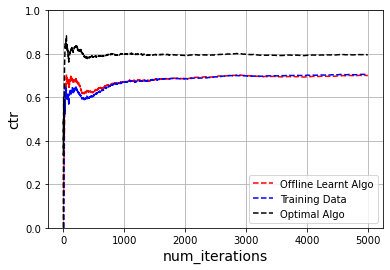

In [6]:
input_df=pd.read_csv('Testdata.csv')
actions = ["politics", "sports", "music", "food", "finance"]
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
env=simple_news()
t_ctr,off_ctr,o_ctr,t_cost_sum,off_cost_sum,o_cost_sum=train_offline(env,vw,input_df,actions)
num_iterations=len(t_ctr)
plot_ctr(num_iterations,t_ctr,off_ctr,o_ctr)
print('Algorithm total reward: '+str(-1*t_cost_sum)+
      ' Offline Data total reward : '+str(-1*off_cost_sum)+' Optimal total reward: ' +str(-1*o_cost_sum))